In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import datasets, transforms
import torchvision.transforms.v2 as T

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns

from tqdm.auto import tqdm
import requests
import zipfile
import pathlib
from pathlib import Path
import shutil
import os
import pandas as pd
import numpy as np
import random
from PIL import Image
from sklearn.model_selection import StratifiedGroupKFold
from typing import Tuple, Dict, List

%load_ext autoreload
%autoreload 1
%aimport CarImageClass
import CarImageClass

device = "cuda" if torch.cuda.is_available() else "cpu"

# home
# train_path = r'D:/Udacity_car_data/data/train'
# test_path = r'D:/Udacity_car_data/data/test'
# train_path_simple = r'D:/Udacity_car_data/data/train_simple'
# test_path_simple = r'D:/Udacity_car_data/data/test_simple'

# laptop
train_path = r'C:\self-driving-car\data\train'
test_path = r'C:\self-driving-car\data\test'
train_path_simple = r'C:\self-driving-car\data\train_simple'
test_path_simple = r'C:\self-driving-car\data\test_simple'
train_path_oo = r'C:\self-driving-car\data\train_one_obj'
test_path_oo = r'C:\self-driving-car\data\test_one_obj'

c:\Users\eblac\anaconda3\envs\torchCPUenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_data = CarImageClass.ImageClass(targ_dir=train_path_simple, transform=None)

In [3]:
train_data[0]

(<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x512>,
 {'image_id': tensor([0]),
  'labels': tensor([1, 7]),
  'boxes': tensor([[ 41., 205., 213., 299.],
          [409., 203., 451., 271.]]),
  'areas': tensor([16168.,  2856.])})

(<Figure size 512x512 with 1 Axes>, <Axes: >)

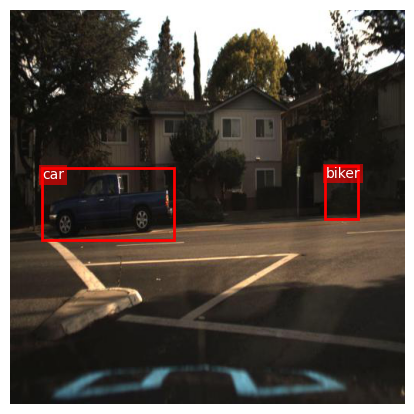

In [4]:
train_data.show_with_box(index=0, color='r', label=True)

In [8]:
train_data[0][1]['boxes']

tensor([[ 41., 205., 213., 299.],
        [409., 203., 451., 271.]])

In [59]:
train_data[0]

(<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x512>,
 {'file_name': '1478019979179856014_jpg.rf.QOsqUw0usMlzD8J2Yusn.jpg',
  'objects': [{'class': 0.0,
    'xmin': 41.0,
    'xmax': 213.0,
    'ymin': 205.0,
    'ymax': 299.0}]})

In [21]:
df = train_data.annotate_df

df

,filename,width,height,class,xmin,ymin,xmax,ymax
0,1478896666143461868_jpg.rf.69deec386ac6ced8887...,512,512,car,22.0,239.0,140.0,310.0
1,1478896666143461868_jpg.rf.69deec386ac6ced8887...,512,512,car,0.0,234.0,53.0,276.0
2,1478896666143461868_jpg.rf.69deec386ac6ced8887...,512,512,car,87.0,202.0,347.0,477.0
3,1478896666143461868_jpg.rf.69deec386ac6ced8887...,512,512,trafficLight-Red,383.0,113.0,394.0,153.0
4,1478896666143461868_jpg.rf.69deec386ac6ced8887...,512,512,pedestrian,390.0,213.0,418.0,363.0
...,...,...,...,...,...,...,...,...
2655,1478898829046799251_jpg.rf.dff0c1d9f9ccaefa0ce...,512,512,empty,NaN,NaN,NaN,NaN
2656,1478898477133442935_jpg.rf.2595d68dad7aac5fc01...,512,512,empty,NaN,NaN,NaN,NaN
2657,1478900684595120186_jpg.rf.680abb263240bed5164...,512,512,empty,NaN,NaN,NaN,NaN
2658,1478895620111892185_jpg.rf.9633d1ffcd0c02e646d...,512,512,empty,NaN,NaN,NaN,NaN


In [35]:
df_img

,filename,width,height,class,xmin,ymin,xmax,ymax
0,1478896666143461868_jpg.rf.69deec386ac6ced8887...,512,512,car,22.0,239.0,140.0,310.0
1,1478896666143461868_jpg.rf.69deec386ac6ced8887...,512,512,car,0.0,234.0,53.0,276.0
2,1478896666143461868_jpg.rf.69deec386ac6ced8887...,512,512,car,87.0,202.0,347.0,477.0
3,1478896666143461868_jpg.rf.69deec386ac6ced8887...,512,512,trafficLight-Red,383.0,113.0,394.0,153.0
4,1478896666143461868_jpg.rf.69deec386ac6ced8887...,512,512,pedestrian,390.0,213.0,418.0,363.0
5,1478896666143461868_jpg.rf.69deec386ac6ced8887...,512,512,pedestrian,409.0,263.0,437.0,360.0
6,1478896666143461868_jpg.rf.69deec386ac6ced8887...,512,512,trafficLight-Red,444.0,179.0,458.0,213.0
7,1478896666143461868_jpg.rf.69deec386ac6ced8887...,512,512,car,491.0,282.0,512.0,412.0


In [ ]:
torch.rand

In [41]:
df_img = df[df['filename'] == df['filename'][0]]


boxes = torch.zeros(len(df_img), 4)
labels = []
areas = torch.zeros(len(df_img))

for i in range(len(df_img)):
    j = 0
    labels.append(df_img['class'].iloc[i])
    for coord in ['xmin', 'ymin', 'xmax', 'ymax']:
        boxes[i, j] = df_img.iloc[i][coord]
        j = j + 1
    
    areas[i] = (boxes[i,2] - boxes[i,0]).clamp(min=0) * (boxes[i,3] - boxes[i,1]).clamp(min=0)
print(labels)
print(boxes)
print(areas)

['car', 'car', 'car', 'trafficLight-Red', 'pedestrian', 'pedestrian', 'trafficLight-Red', 'car']
tensor([[ 22., 239., 140., 310.],
        [  0., 234.,  53., 276.],
        [ 87., 202., 347., 477.],
        [383., 113., 394., 153.],
        [390., 213., 418., 363.],
        [409., 263., 437., 360.],
        [444., 179., 458., 213.],
        [491., 282., 512., 412.]])
tensor([ 8378.,  2226., 71500.,   440.,  4200.,  2716.,   476.,  2730.])


In [53]:
torch.tensor([1], dtype=torch.int64).dtype

torch.int64

In [56]:
torch.zeros(1, dtype=torch.int64)

tensor([0])

In [6]:
# Create transform (no data augmentation)
data_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

In [8]:
data_transform.transforms

[Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True),
 RandomHorizontalFlip(p=0.5),
 ToTensor()]

In [6]:
# 1. Load and transform data
train_data = CarImageClass.ImageClassSimple(targ_dir=train_path_oo, transform=None)
test_data = CarImageClass.ImageClassSimple(targ_dir=test_path_oo, transform=None)

# 2. Turn data into DataLoaders
# Setup batch size and number of workers 
BATCH_SIZE = 32
#NUM_WORKERS = os.cpu_count()
#print(f"Creating DataLoader's with batch size {BATCH_SIZE} and {NUM_WORKERS} workers.")

# Create DataLoader's
train_dataloader = DataLoader(train_data, 
                                     batch_size=BATCH_SIZE, 
                                     shuffle=True, 
                                     #num_workers=NUM_WORKERS,
                                     )

test_dataloader = DataLoader(test_data, 
                                    batch_size=BATCH_SIZE, 
                                    shuffle=False, 
                                    #num_workers=NUM_WORKERS,
                                    )

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x1999e951d20>,
 <torch.utils.data.dataloader.DataLoader at 0x1999e951cf0>)

(<Figure size 640x480 with 1 Axes>, <Axes: >)

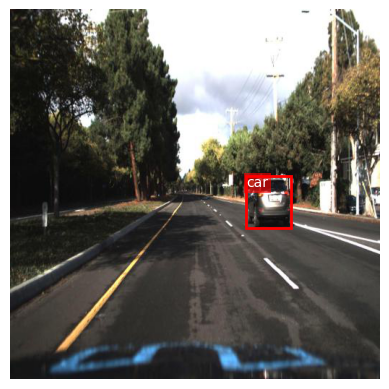

In [16]:
train_data.show_with_box(index=8, color='r', label=True)